In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
#FILE_NAME     = '1_wifiAP_0.5_traffic.log'
TRAFFIC_LEVELS  = [0, 0.5, 1]
BATTERY_CHARGE = 2.85*2
TIME_EXPERIMENT = 180*60


In [39]:
netLatency          = {}
netPathStability    = {}
netReliability      = {}
accumulated_charge  = {}


for t in TRAFFIC_LEVELS:
    netLatency[t]   = [0 for x in range(4)]
    netPathStability[t]   = [0 for x in range(4)]
    netReliability[t]   = [0 for x in range(4)]
    accumulated_charge[t]   = [0 for x in range(4)]
    for n in range(0,4):
        if n==0 and t!=0:
            continue
        with open('{0}_wifiAP_{1}_traffic.log'.format(n,t), 'r') as f:
            line = f.readline()
            charge = {}
            while line:
                line  = json.loads(line)
                if line['name'] == 'snapshot':
                    netLatency[t][n]    = line['snapshot']['getNetworkInfo']['netLatency']
                    netPathStability[t][n]    = line['snapshot']['getNetworkInfo']['netPathStability']
                    netReliability[t][n]    = line['snapshot']['getNetworkInfo']['netReliability']

                if 'hr' in line.keys():
                    if 'Device' in line['hr'].keys():
                        if not(line['mac'] in charge):
                            charge[line['mac']]     = []
                        charge[line['mac']] += [line['hr']['Device']['charge'],]
                line  = f.readline()
            for c in charge:
                charge[c] = charge[c][-1]
            accumulated_charge[t][n] = charge
        


In [40]:
def plot_statistics(data, title, name):
    for n in range(3,0,-1):
        data_to_plot = []
        for l in data:
            data_to_plot += [data[l][n],]
        plt.plot(TRAFFIC_LEVELS, data_to_plot, label='{0} wifi networks'.format(n), marker='o')

    plt.plot(0,data[0][0], marker = 'o', label='0 wifi networks')
    plt.xlabel('Traffic Ratio')
    plt.ylabel(name)

    plt.title(title)

    plt.legend()
    plt.savefig('{0}.png'.format(title), dpi=200)
    plt.show()
    

In [41]:
max_charge     = {}
time_to_live   = {}
charge         = {}
plot_charge    = []
labels_boxplot = []      
for t in TRAFFIC_LEVELS:
    max_charge[t]   = [0 for x in range(4)]
    time_to_live[t]   = [0 for x in range(4)]
    charge[t]   = [0 for x in range(4)]
    for n in range(0,4):
        if n==0 and t!=0:
            continue
        max_charge[t][n] = 0
        charge[t][n]     = []
        try:
            for c in accumulated_charge[t][n]:
                charge[t][n] += [accumulated_charge[t][n][c],]
                if accumulated_charge[t][n][c] >  max_charge[t][n]:
                    max_charge[t][n] = accumulated_charge[t][n][c]
        except:
            pass
        plot_charge+=[charge[t][n],]
        labels_boxplot += ['{0}Tr_{1}Wi'.format(t,n),]
        if max_charge[t][n] != 0:
            try:
                time_to_live[t][n] = (BATTERY_CHARGE*TIME_EXPERIMENT)/(max_charge[t][n]*24*365)*1000
            except:
                pass


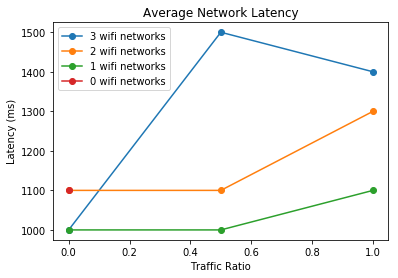

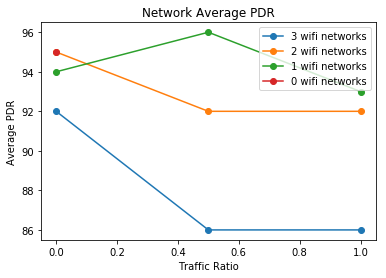

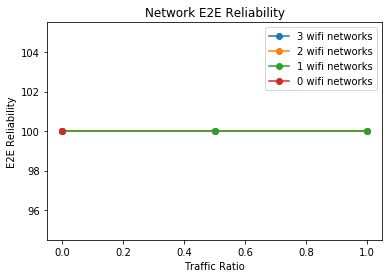

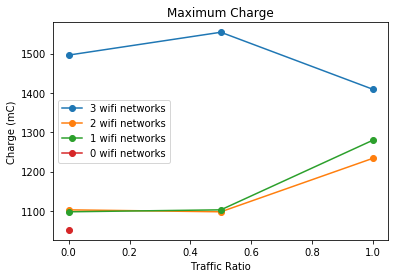

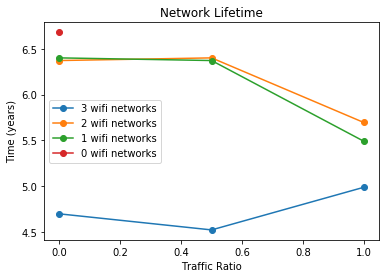

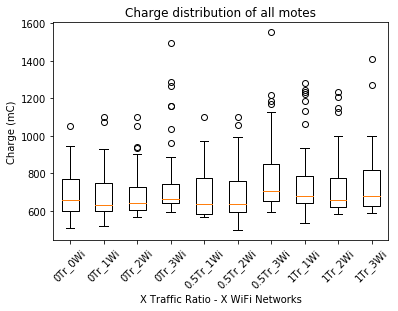

In [42]:
plot_statistics(netLatency, 'Average Network Latency', 'Latency (ms)')
plot_statistics(netPathStability, 'Network Average PDR', 'Average PDR')
plot_statistics(netReliability, 'Network E2E Reliability', 'E2E Reliability')
plot_statistics(max_charge, 'Maximum Charge', 'Charge (mC)')
plot_statistics(time_to_live, 'Network Lifetime', 'Time (years)')

plt.boxplot(plot_charge, labels=labels_boxplot)
plt.xticks(rotation=45)
plt.xlabel('X Traffic Ratio - X WiFi Networks')
plt.ylabel('Charge (mC)')
plt.title('Charge distribution of all motes')
plt.savefig('Charge distribution of all motes.png',pad_inches=0.1, bbox_inches='tight', dpi = 200)
plt.show()